In [ ]:
# set() op on langs
# 1/n weight vector per state

In [1]:
#import packages
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:

from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.optim as optim

#clearing output
from IPython.display import clear_output

In [3]:
languages = []
data = []
X = []
y = []

In [4]:
MIN_OCCURENCE = 3

def process_data(base_path):
    df = pd.read_csv(base_path)
    df = df[df.last_name != "lnu"]  # Remove last name unknows
    df = df[
        df.groupby("last_name")["last_name"].transform("count").ge(MIN_OCCURENCE)
    ]  # Remove all last names that occur less than MIN_OCCURANCE times
    df = df[(df.state != "wb")]
    df = df[(df.state != "tn")]
    df = df[df.last_name.str.len() > 2]
    return df

In [5]:
base_dir = "/Users/dhingratul/Documents/instate_data"
fid = "instate_processed.csv.gz"
# Data
print("Processing data")
df = process_data(os.path.join(base_dir, fid))

Processing data


In [6]:
def split_tr_te(df):
    samplelist = df["last_name"].unique()
    training_samp, test_samp = train_test_split(
        samplelist, train_size=0.8, test_size=0.2, random_state=5, shuffle=True
    )
    training_data = df[df["last_name"].isin(training_samp)]
    test_data = df[df["last_name"].isin(test_samp)]
    return training_data, test_data

In [7]:
df.head()

,sex,state,last_name
0,Male,andaman,datta
1,Female,andaman,devi
2,Male,andaman,krishna
3,Male,andaman,sekhar
4,Male,andaman,toppo


In [8]:
df["state"].unique()

array(['andaman', 'arunachal', 'dadra', 'daman', 'goa', 'jk', 'manipur',
       'meghalaya', 'mizoram', 'nagaland', 'puducherry', 'andhra',
       'assam', 'bihar', 'chandigarh', 'delhi', 'guj', 'har', 'jha',
       'kar', 'kerala', 'maharashtra', 'mp', 'odi', 'punjab', 'rajasthan',
       'sikkim', 'tel', 'tripura', 'up', 'utt'], dtype=object)

In [9]:
statecolname = "state"
state_lang = pd.read_csv("../data/state_to_languages_clean.csv")

In [10]:
state_lang.head(35)

,state,official_languages,addl_official_languages,most_spoken_lang,second_most_spoken_lang,third_most_spoken_lang,fourth_most_spoken_lang,fifth_most_spoken_lang
0,andaman,"Hindi,English",NaN,Bengali,Hindi,Tamil,Telugu,Malayalam
1,andhra,Telugu,Urdu,Telugu,Urdu,Tamil,Chenchu,Kannada
2,arunachal,English,NaN,Nishi,Adi,Apatani,Tagin,Hindi
3,assam,Assamese,"Bengali,Bodo",Assamese,Bengali,Bodo,Hindi,Nepali
4,bihar,Hindi,Urdu,"Hindi,Bihari",Maithili,Urdu,Bengali,Santali
5,chandigarh,English,NaN,Hindi,Punjabi,Urdu,Nepali,Bengali
6,dadra,"Hindi,English",Gujarati,Gujarati,Hindi,Marathi,Konkani,Bengali
7,daman,"Hindi,English",Gujarati,Gujarati,Hindi,Marathi,Konkani,Bengali
8,delhi,"Hindi,English","Urdu,Punjabi",Hindi,Punjabi,Urdu,Bengali,Maithili
9,goa,Konkani,Marathi,Konkani,Marathi,Hindi,Kannada,Urdu


In [11]:
state_lang.columns[3:6]

Index(['most_spoken_lang', 'second_most_spoken_lang',
       'third_most_spoken_lang'],
      dtype='object')

In [12]:
# Top-3 languages
state_lang['top_3_languages'] = state_lang[state_lang.columns[3:6]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

In [13]:
state_lang.columns[3:6]

Index(['most_spoken_lang', 'second_most_spoken_lang',
       'third_most_spoken_lang'],
      dtype='object')

In [14]:
state_lang.head()

,state,official_languages,addl_official_languages,most_spoken_lang,second_most_spoken_lang,third_most_spoken_lang,fourth_most_spoken_lang,fifth_most_spoken_lang,top_3_languages
0,andaman,"Hindi,English",NaN,Bengali,Hindi,Tamil,Telugu,Malayalam,"Bengali,Hindi,Tamil"
1,andhra,Telugu,Urdu,Telugu,Urdu,Tamil,Chenchu,Kannada,"Telugu,Urdu,Tamil"
2,arunachal,English,NaN,Nishi,Adi,Apatani,Tagin,Hindi,"Nishi,Adi,Apatani"
3,assam,Assamese,"Bengali,Bodo",Assamese,Bengali,Bodo,Hindi,Nepali,"Assamese,Bengali,Bodo"
4,bihar,Hindi,Urdu,"Hindi,Bihari",Maithili,Urdu,Bengali,Santali,"Hindi,Bihari,Maithili,Urdu"


In [15]:
state_lang = state_lang.drop(['official_languages', 'addl_official_languages', 'most_spoken_lang', 'second_most_spoken_lang', 'third_most_spoken_lang', 'fourth_most_spoken_lang', 'fifth_most_spoken_lang'], axis=1)

In [16]:
state_lang.head(36)

,state,top_3_languages
0,andaman,"Bengali,Hindi,Tamil"
1,andhra,"Telugu,Urdu,Tamil"
2,arunachal,"Nishi,Adi,Apatani"
3,assam,"Assamese,Bengali,Bodo"
4,bihar,"Hindi,Bihari,Maithili,Urdu"
5,chandigarh,"Hindi,Punjabi,Urdu"
6,dadra,"Gujarati,Hindi,Marathi"
7,daman,"Gujarati,Hindi,Marathi"
8,delhi,"Hindi,Punjabi,Urdu"
9,goa,"Konkani,Marathi,Hindi"


In [17]:
# Convert to List
state_lang.top_3_languages = state_lang.top_3_languages.str.split(',')

In [18]:
state_lang.head(35)

,state,top_3_languages
0,andaman,"[Bengali, Hindi, Tamil]"
1,andhra,"[Telugu, Urdu, Tamil]"
2,arunachal,"[Nishi, Adi, Apatani]"
3,assam,"[Assamese, Bengali, Bodo]"
4,bihar,"[Hindi, Bihari, Maithili, Urdu]"
5,chandigarh,"[Hindi, Punjabi, Urdu]"
6,dadra,"[Gujarati, Hindi, Marathi]"
7,daman,"[Gujarati, Hindi, Marathi]"
8,delhi,"[Hindi, Punjabi, Urdu]"
9,goa,"[Konkani, Marathi, Hindi]"


In [19]:
res = df.merge(state_lang, left_on = statecolname, right_on = 'state', how = 'left')

In [20]:
res.head()

,sex,state,last_name,top_3_languages
0,Male,andaman,datta,"[Bengali, Hindi, Tamil]"
1,Female,andaman,devi,"[Bengali, Hindi, Tamil]"
2,Male,andaman,krishna,"[Bengali, Hindi, Tamil]"
3,Male,andaman,sekhar,"[Bengali, Hindi, Tamil]"
4,Male,andaman,toppo,"[Bengali, Hindi, Tamil]"


In [21]:
res = res.drop(['sex', 'state'], axis=1)

In [22]:
res.head()

,last_name,top_3_languages
0,datta,"[Bengali, Hindi, Tamil]"
1,devi,"[Bengali, Hindi, Tamil]"
2,krishna,"[Bengali, Hindi, Tamil]"
3,sekhar,"[Bengali, Hindi, Tamil]"
4,toppo,"[Bengali, Hindi, Tamil]"


In [23]:
res.shape

(427762655, 2)

In [24]:
training_data, test_data = split_tr_te(res)

In [25]:
training_data.head()

,last_name,top_3_languages
2,krishna,"[Bengali, Hindi, Tamil]"
3,sekhar,"[Bengali, Hindi, Tamil]"
4,toppo,"[Bengali, Hindi, Tamil]"
5,kiran,"[Bengali, Hindi, Tamil]"
9,minj,"[Bengali, Hindi, Tamil]"


In [26]:
test_data.head()

,last_name,top_3_languages
0,datta,"[Bengali, Hindi, Tamil]"
1,devi,"[Bengali, Hindi, Tamil]"
6,ekka,"[Bengali, Hindi, Tamil]"
7,ekka,"[Bengali, Hindi, Tamil]"
8,yadav,"[Bengali, Hindi, Tamil]"


In [27]:
training_data.shape

(332973252, 2)

In [28]:
test_data.shape

(94789403, 2)

In [29]:
# Shrink Train set by 10x
training_data_shrink = training_data.sample(33297325)

In [30]:
def prepare_unrolled_data(df):
    # Add unrolling language
    df = df.explode("top_3_languages", ignore_index=False)
    X = df["last_name"].tolist()
    y = df["top_3_languages"].tolist()
    return X, y

In [31]:
def prepare_test_data(df):
    # Add unrolling language
    X = df["last_name"].tolist()
    y = df["top_3_languages"].tolist()
    return X, y

In [32]:
X_te, y_te = prepare_test_data(test_data)

In [33]:
X_te[:5], y_te[:5]

(['datta', 'devi', 'ekka', 'ekka', 'yadav'],
 [['Bengali', 'Hindi', 'Tamil'],
  ['Bengali', 'Hindi', 'Tamil'],
  ['Bengali', 'Hindi', 'Tamil'],
  ['Bengali', 'Hindi', 'Tamil'],
  ['Bengali', 'Hindi', 'Tamil']])

In [34]:
X_tr, y_tr = prepare_unrolled_data(training_data_shrink)

In [35]:
languages = sorted(list(set(y_tr)))
n_languages = len(languages)

In [36]:
languages

['Adi',
 'Apatani',
 'Assamese',
 'Bengali',
 'Bihari',
 'Bodo',
 'Chakma',
 'Dogri',
 'English',
 'Garo',
 'Gondi',
 'Gujarati',
 'Hindi',
 'Kannada',
 'Kashmiri',
 'Khasi',
 'Kokborok',
 'Konkani',
 'Kumauni',
 'Maithili',
 'Malayalam',
 'Marathi',
 'Meitei',
 'Mizo',
 'Naga',
 'Nepali',
 'Nishi',
 'Odia',
 'Pahari',
 'Punjabi',
 'Santali',
 'Tamil',
 'Telugu',
 'Tulu',
 'Urdu']

In [37]:
n_languages

35

In [38]:
all_letters = string.ascii_letters
n_letters = len(all_letters)

In [39]:
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [40]:
name_rep("datta")

tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.]

In [41]:
#function to create lang representation

def nat_rep(language):
    return torch.tensor([languages.index(language)], dtype = torch.long)

In [42]:
def dataloader_te(npoints, X_, y_):
    random.seed(9001)
    # Adds top-3 states
    to_ret = []
    for i in range(npoints):
        nat_rep_list = []
        index_ = np.random.randint(0, len(X_) - 1)
        name, language = X_[index_], y_[index_] #get the data at the random index
        for _language in language:
            nat_rep_list.append(nat_rep(_language))
        to_ret.append((name, language, name_rep(name), nat_rep_list))

    return to_ret

In [43]:
def dataloader_unrolled(npoints, X_, y_):
    random.seed(9001)
    # Adds top-3 states
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(0, len(X_) - 1)
        name, language = X_[index_], y_[index_] #get the data at the random index
        to_ret.append((name, language, name_rep(name), nat_rep(language)))

    return to_ret

In [44]:
dataloader_unrolled(1, X_tr, y_tr)

[('kutty',
  'Malayalam',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0.,

In [45]:
dataloader_te(1, X_te, y_te)

[('segs',
  ['Malayalam', 'Tamil', 'Tulu'],
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0.]],
  
          [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0.]],
  
          [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0

In [46]:
#function to make inference

def infer(net, name):
    net.eval()
    name_ohe = name_rep(name)
    hidden = net.init_hidden()

    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)

    return output

In [47]:
#create a function to evaluate model

def eval_all(net, n_points, k, X_, y_):
    data_ = dataloader_te(n_points, X_, y_)
    correct = 0
    ctr = 0
    for name, language, name_ohe, lang_rep_list in data_:
        lang_rep_list_exploded = []
#         ctr += 1
#         print(f"{ctr}/{n_points}")
        output = infer(net, name) #prediction
        val, indices = output.topk(k) #get the top k predictions
        for _lang in lang_rep_list:
            lang_rep_list_exploded.extend(_lang.numpy().flatten().tolist())
        if bool(set(lang_rep_list_exploded) & set(indices.numpy().flatten().tolist())):  
            correct += 1
    accuracy = correct/n_points
    return accuracy

In [48]:

#function to train the data

m = nn.LogSoftmax(dim=1)

def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader_unrolled(n_points, X_tr, y_tr)
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
            
        loss = criterion(m(output), lang_rep)
        loss.backward(retain_graph=True)
#         torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25)
        
        total_loss += loss
        
    opt.step()       
            
    return total_loss/n_points

In [49]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq = 5, fid='net_rnn_eval.txt', eval_step = 250):
    
    criterion = nn.NLLLoss() #define a loss function
    opt = optim.Adam(net.parameters(), lr = lr) #define a optimizer
    
    loss_arr = np.zeros(n_batches + 1)

    #iterate through all the batches
    for i in range(n_batches):
        loss_arr[i + 1] = (loss_arr[i]*i + train(net, opt, criterion, batch_size))/(i + 1)
        if i % eval_step == 0:
            with open(fid, 'a') as f:
                f.write(f"n_batches:{i}, loss:{round(loss_arr[i],4)}\n")
        if i%display_freq == display_freq - 1:
            clear_output(wait = True)
            print("Iteration number ", i + 1, 'Loss:', round(loss_arr[i],4))
            plt.figure()
            plt.plot(loss_arr[1:i], "-*")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.show()
            print("\n\n")


In [50]:
#define a basic rnn network

class RNN_net(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        #declare the hidden size for the network
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) #input to hidden layer
        self.i2o = nn.Linear(input_size + hidden_size, output_size) #input to output layer
        self.softmax = nn.LogSoftmax(dim = 1) #softmax for classification
    
    def forward(self, input_, hidden):
        combined = torch.cat((input_, hidden), 1) #concatenate tensors on column wise
        hidden = self.i2h(combined) #generate hidden representation
        output = self.i2o(combined) #generate output representation
        output = self.softmax(output) #get the softmax label
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

Iteration number  1000 Loss: 2.0997


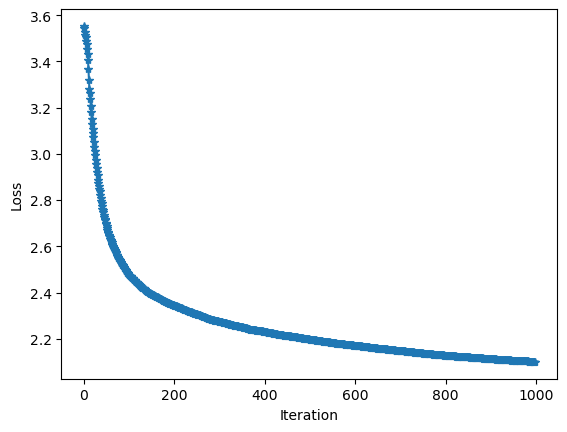

In [51]:

#declare all the parameters

n_hidden = 512
net_rnn = RNN_net(n_letters, n_hidden, n_languages)
train_setup(net_rnn, lr = 3e-4, n_batches = 1000, batch_size = 256, fid='net_rnn_eval.txt')

In [52]:
eval_all(net_rnn, 10000, 1, X_te, y_te)

0.8886

In [53]:
#LSTM class

class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size) #LSTM cell
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)

    def forward(self, input_, hidden):
        out, hidden = self.lstm_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden[0])
        output = self.softmax(output)
        return output.view(1, -1), hidden

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

Iteration number  250 Loss: 2.3719


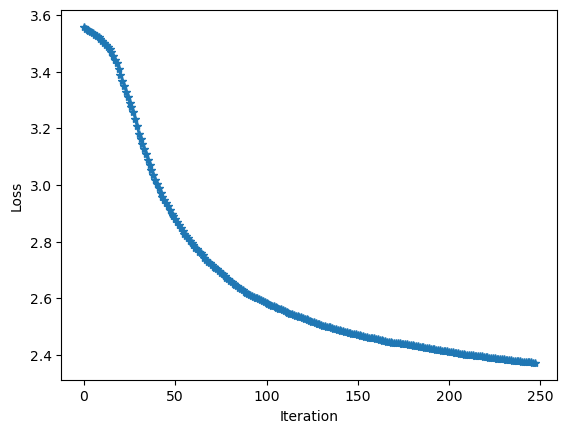

In [54]:
#create hyperparameters
n_hidden = 512
net_lstm = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net_lstm, lr = 3e-4, n_batches = 250, batch_size = 256, fid='net_lstm_eval.txt')

In [55]:
eval_all(net_lstm, 10000, 1, X_te, y_te)

0.7894

In [56]:
#GRU implementation

class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size) #gru cell
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)
    
    def forward(self, input_, hidden):
        out, hidden = self.gru_cell(input_.view(1, 1, -1), hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output.view(1, -1), hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

Iteration number  250 Loss: 2.2282


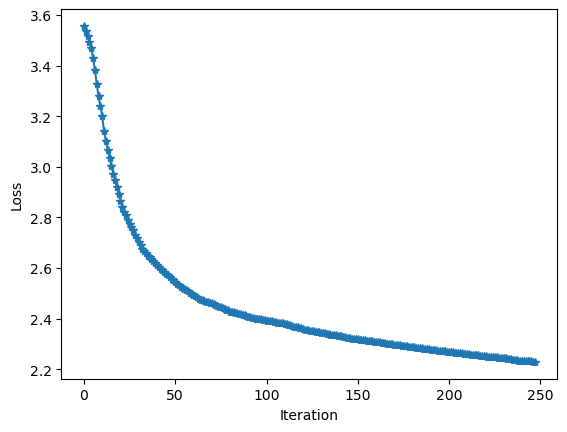

In [57]:
#hyperparameters

n_hidden = 2048
net_gru = GRU_net(n_letters, n_hidden, n_languages)
train_setup(net_gru, lr = 3e-4, n_batches = 250, batch_size = 256, fid='net_gru_eval.txt')

In [58]:
eval_all(net_gru, 10000, 1, X_te, y_te)

0.8957